<a href="https://colab.research.google.com/github/chriswmann/keras-google-colab-tpu/blob/master/keras_tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running Keras on Google Colab with TPU Acceleration

## Introduction

The purpose of this notebook is a demonstration of running Keras/TensorFlow on Google Colabatory with TPU acceleration.  There are a number of resources for this, such as Google's notebooks here:

1. https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/shakespeare_with_tpu_and_keras.ipynb
2. https://colab.research.google.com/gist/ceshine/f196d6b030adb1ec3a8d0b50642709dc/keras-fashion-mnist-tpu.ipynb

In order to try Keras with a TPU I needed a model.  I wanted to create something from scratch.  I happened to come across [this question](https://ai.stackexchange.com/questions/1508/which-neural-network-has-capabilities-of-sorting-input) on [ai.stackexchange.com](ai.stackexchange.com) and decided upon making a model which would sort a small array of random integers.  To make this more challenging than a simple sort, I've used a regression model.

Briefly, the main features this notebook comprises:
1. A data generator which will produce train and test sets of random and sorted arrays respectively.
2. A simple artificial neural network which can be run on CPU, GPU or TPU.
3. A basic, home rolled random search for hyperparameter tuning.
4. Simple visualisation of the results.



In [1]:
import datetime as dt
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint as pp
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

def now():
    return dt.datetime.now()

try:
    # This address identifies the TPU we'll use when configuring TensorFlow.
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    ACCELERATION = 'tpu'
    print('TPU acceleration')
except KeyError as e:
    print('GPU acceleration')
    ACCELERATION = 'gpu'
        

Using TensorFlow backend.


TPU acceleration


In [0]:
# define custom loss function to use RMSE in the NN model
def rmse(y_true, y_pred):
    
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

## Data Generation

In [0]:
class dataGenerator():
    
    """Generate train and test data for machine learning exercises.
    
    This class generates train and test data in the form of random arrays 
    as inputs and sorted arrays as outputs.
    
    Usage:
        Call set_config(size_to_sort, limit, train_samples, test_samples)
        Call gen_data()
        
    Returns:
        X_train, X_test, y_train, y_test
    """
    
    def __init__(self):
        
        """Instantiate the class with a flag to indicate the data generation
        configuration has not been set yet.
        """
        
        self.config = False
        
    def check_config_set(self):
        
        assert self.config, """Error: Config not set. Call set_config(size_to_sort, limit, train_samples, test_samples)"""

    def set_config(self, size_to_sort, limit, train_samples, test_samples):
        
        self.train_samples = train_samples    
        self.test_samples = test_samples
        self.size_to_sort = size_to_sort
        self.limit = limit
        self.config = True
        
    def gen_rand_array(self):
        
        return np.random.randint(0, self.limit, self.size_to_sort)

    
    def gen_data(self):
        
        self.check_config_set()
        
        self.X_train = np.array([self.gen_rand_array() for i in range(self.train_samples)]).astype(np.float64)
        self.y_train = np.sort(self.X_train, axis=1)
    
        self.X_test = np.array([self.gen_rand_array() for i in range(self.test_samples)]).astype(np.float64)
        self.y_test = np.sort(self.X_test, axis=1)
        
        return self.X_train, self.X_test, self.y_train, self.y_test

In [0]:
class checkUnique():
    
    """Check that a set of hyperparameters have not been previously generated.
    
    As the random search function in this notebook is very basic, this class 
    can be used to avoid wasting compute time by storing hyperparameters
    and checking if they've been assessed already.
    
    This class is used as part of a while loop in this notebook.
    
    Usage:
        check_unique(activation, hidden_layers, units, optimiser)
        
    Returns:
        True if the given hyperparameters have not been used already.
        False if the given hyperparameters have already been used.
    """
    
    def __init__(self):
        
        self.trial_param_history = []
        
    def check_unique(self, activation, hidden_layers, units, optimiser):
        
        self.activation = activation
        self.hidden_layers = hidden_layers
        self.units = units
        self.optimiser = optimiser
        self.trial_param_summary = (self.activation,
                                    self.hidden_layers,
                                    self.units,
                                    self.optimiser)
        
        if self.trial_param_summary in self.trial_param_history:
            return False
        else:
            self.trial_param_history.append(self.trial_param_summary)
            return True

In [0]:
class customLogger(keras.callbacks.Callback):
    
    """Provide custom logging functionality for use during model fitting.
    
    Custom functionality includes the time taken for a given number (n) of 
    epochs to complete.
    """
    
    def __init__(self, n):
        self.__n = n
        self.__start_time = now()
        self.__new_time = None

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.__n == 0:
            if self.__new_time:
                self.__old_time = self.__new_time
            else:
                self.__old_time = self.__start_time
            self.__new_time = now()
            self.__curr_loss = logs.get('loss')
            self.__val_loss = logs.get('val_loss')
            self.__epoch_string = f'Epoch: {epoch:<5}'
            self.__loss_string = f'loss: {self.__curr_loss:<15.6f}'
            self.__val_loss_string = f'val loss: {self.__val_loss:<15.6f}'
            self.__time_string = f'time: {now().strftime("%H:%M:%S"):<10}'
            self.__delta_t = str(self.__new_time - self.__old_time)
            self.__delta_t_string = f'delta_t: {self.__delta_t:<20}'
            print(self.__epoch_string,
                  self.__loss_string,
                  self.__val_loss_string,
                  self.__time_string,
                  self.__delta_t_string)
            

In [0]:
## learning rate reduction at plateua in loss
patience = 10
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                             factor=0.1,
                                             patience=patience,
                                             verbose=1,
                                             mode='min',
                                             min_delta=0.01,
                                             cooldown=0,
                                             min_lr=1e-6)

## early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              min_delta=0.0001,
                                              patience=patience * 2,
                                              verbose=1,
                                              mode='min')

In [0]:
from keras.utils import print_summary
from tensorflow.keras.utils import Sequence

adam = tf.train.AdamOptimizer()#lr=0.001, beta_1=0.9, beta_2=0.999)

In [0]:
class artificialNeuralNetwork():
    
    """Build, train and assess an artificial neural network.
    
    Todo:
        Improve get_params method to allow **kwargs to be used but also 
        provide defaults.  Currently allows a dictionary to be passed 
        but this must include all required parameters.
    """
    
    def __init__(self, acceleration='tpu'):
        
        """Instantiate the class with the acceleration type, the initial 
        trial count, a blank optimisation history and placeholders for
        parameter values and predictions.
        """
        
        self.acceleration = acceleration
        self.trial = 0
        self.optimisation_history = {}
        
        self.params = None
        self.y_pred = None
        
    def get_params(self, **kwargs):
        
        """Get the paramters to use for building and using the NN.
        """
        
        self.passed_args = kwargs
        self.default_args = {'activation': 'relu',
                             'callbacks': None,
                             'epochs': 100,
                             'mini_batch_size': None,
                             'n_hidden_layers': 8,
                             'n_trials': 20,
                             'n_units': 4,
                             'optimiser': 'adam',
                             'size_to_sort': None,
                             'validation_split': 0.25,
                             'verbose': 0}
        
        self.diff = list(set(self.default_args.keys()) - set(self.passed_args.keys()))

        assert not self.diff, f"Error, missing required parameters and I don't know how to work around this yet. {self.diff}"
        
        self.activation = self.passed_args['activation']
        self.callbacks = self.passed_args['callbacks']
        self.epochs = self.passed_args['epochs']

        if self.passed_args['mini_batch_size']:
            self.mini_batch_size = self.passed_args['mini_batch_size']
        elif self.acceleration == 'gpu':
            self.mini_batch_size = 64
        elif self.acceleration == 'tpu':
            self.mini_batch_size = 2096 * 8

        self.n_hidden_layers = self.passed_args['n_hidden_layers']
        self.n_units = self.passed_args['n_units']
        self.n_trials = self.passed_args['n_trials']
        self.optimiser = self.passed_args['optimiser']
        self.size_to_sort = self.passed_args['size_to_sort']
        self.validation_split = self.passed_args['validation_split']
        self.verbose = self.passed_args['verbose']
        
        self.params = {'activation': self.activation,
                       'callbacks': self.callbacks,
                       'epochs': self.epochs,
                       'mini_batch_size': self.mini_batch_size,
                       'n_hidden_layers': self.n_hidden_layers,
                       'n_units': self.n_units,
                       'n_trials': self.n_trials,
                       'optimiser': self.optimiser,
                       'size_to_sort': self.size_to_sort,
                       'validation_split': self.validation_split,
                       'verbose': self.verbose}
                   
    def run_trial(self, X_train, y_train, X_test, y_test):
        
        """ Run a single trial comprising training and test.
        
        Arguments:
        X_train -- train input data np.ndarray
        y_train -- train target data np.ndarray
        X_test -- test input data np.ndarray
        y_test -- test target data np.ndarray
        """

        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        
        self.dims_check = all([x.ndim==2 for x in [X_train, y_train, X_test, y_test]])
        self.shapes_set = set([x.shape[1] for x in [X_train, y_train, X_test, y_test]])
        self.shape_check = len(self.shapes_set) == 1
        
        assert self.dims_check, f"Input arrays should be 2D, got {[x.ndim for x in [X_train, y_train, X_test, y_test]]}"
        assert self.shape_check, f"Input arrays' second axes should match, got {[x.shape for x in [X_train, y_train, X_test, y_test]]}"
        assert self.params, "No params defined, call get_params method."
        
        if not self.size_to_sort:
            self.size_to_sort = list(self.shapes_set)[0]
                   
        print("==============================")
        print(f"  Running trial {self.trial:<4} of {self.n_trials:>4}")
        print("==============================")
        
        self.build_model()
        self.fit(self.X_train, self.y_train),
        self.predict(self.X_test)
        self.error(self.y_pred, self.y_test)
                
        self.val_loss_scalar = self.history.history['loss'][-1]
        self.optimisation_history[self.val_loss_scalar] = self.params
        self.trial += 1

    def build_model(self):
        
        """Build the NN.
        
        Uses a mixture of Model and Sequential APIs.  The Sequential API 
        is used to build the hidden layers in a for loop.  The Model API 
        then wraps these with the input and output layers."""
        
        self.model = tf.keras.Sequential()

        for i in range(self.n_hidden_layers):
            self.model.add(tf.keras.layers.Dense(self.n_units))
            self.model.add(tf.keras.layers.Activation(self.activation))
            
        self.input = tf.keras.Input(shape=(self.size_to_sort,), dtype=tf.float32)
        self.model = self.model(self.input)
        self.predictions = tf.keras.layers.Dense(self.size_to_sort)(self.model)

        self.model = tf.keras.Model(inputs=self.input, outputs=self.predictions)
        
        if self.verbose:
            print_summary(self.model)
        else:
            print(f"Depth: {self.n_hidden_layers + 2:3}    Units: {self.n_units:3}")
        
        if self.acceleration == 'tpu':
            self.strategy = tf.contrib.tpu.TPUDistributionStrategy(
                tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER))
            
            self.model = tf.contrib.tpu.keras_to_tpu_model(
                self.model,
                strategy=self.strategy)
            
        self.model.compile(optimizer=self.optimiser,
                           loss=rmse)
        
        return self.model

    def fit(self, X, y):
        
        """Fit the NN to the training data."""
        
        self.X_fit = X
        self.y_fit = y
        
        print(f"Training for up to {self.epochs} epochs")

        self.history = self.model.fit(self.X_fit, self.y_fit,
                                      validation_split=self.validation_split,
                                      epochs=self.epochs,
                                      batch_size=self.mini_batch_size,
                                      verbose=self.verbose,
                                      callbacks=self.callbacks)
        return self.history
    
    def predict(self, X_pred):
        
        """Make a prediction with the NN."""

        self.X_pred = X_pred
        
        self.y_pred = self.model.predict(self.X_pred)
    
        return self.y_pred
        
    def error(self, y_pred, y_true):
        
        """Compute the RMSE error of the prediction."""
        
        self.y_test = y_true
        self.y_pred = y_pred
            
        self.val_loss = K.sqrt(K.mean(K.square(self.y_pred - self.y_test),
                                      axis=-1))
        
    def get_results(self):
        
        """Return the optimisation history (dict[loss]:[paramters]) 
        and Keras' history object from training.
        """
        
        return self.optimisation_history, self.history

## Hyperparameter Tuning

In [0]:
from random import choice

params = {'activations': ['relu', 'tanh'],
          'n_hidden_layers': [2, 6, 14, 30, 62],
          'n_units_list': [2, 4, 8, 16, 32],
          'optimisers': ['adam', 'adagrad', 'rmsprop'],
         }

n_trials  = 20
max_trials = np.prod([len(v) for k, v in params.items()])
run_trials = min(n_trials, max_trials)

In [0]:
epochs = 1000
limit = 1_000_000
mini_batch_size = 2048 * 8
size_to_sort = 4
test_samples = 8
train_samples = 2048 * 8 * 5
validation_split = 0.25
verbose = 0

In [0]:

dg = dataGenerator()
dg.set_config(size_to_sort=size_to_sort, limit=limit,
              train_samples=train_samples, test_samples=test_samples)

X_train, X_test, y_train, y_test = dg.gen_data()


In [0]:

mms = MinMaxScaler(feature_range=(-1, 1))
X_train = mms.fit_transform(X_train)
X_test = mms.fit_transform(X_test)

callbacks = [customLogger(n=int(epochs/10)), rlrop, early_stop]


In [13]:

objective = artificialNeuralNetwork(ACCELERATION)

tf.keras.backend.clear_session()
# INFO, WARN or ERRROR
tf.logging.set_verbosity(tf.logging.ERROR)

cu = checkUnique()

trial = 0
while trial <= run_trials:
    
    activation = choice(params['activations'])
    n_hidden_layers = choice(params['n_hidden_layers'])
    n_units = choice(params['n_units_list'])
    optimiser = choice(params['optimisers'])
    
    if cu.check_unique(activation, n_hidden_layers, n_units, optimiser):
        
        trial_params = {'activation': activation,
                  'callbacks': callbacks,
                  'epochs': epochs,
                  'mini_batch_size': mini_batch_size,
                  'n_hidden_layers': n_hidden_layers,
                  'n_trials': n_trials,
                  'n_units': n_units,
                  'optimiser': optimiser,
                  'size_to_sort': size_to_sort,
                  'validation_split': validation_split,
                  'verbose': verbose}
        
        objective.get_params(**trial_params)

        objective.run_trial(X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test)

        trial += 1

  Running trial 0    of   20
Depth:  16    Units:   4
Training for up to 1000 epochs
Epoch: 0     loss: 561100.937500   val loss: 560761.975000   time: 05:51:34   delta_t: 0:00:32.581075      
Epoch: 100   loss: 561097.812500   val loss: 560758.862500   time: 05:51:46   delta_t: 0:00:12.095617      
Epoch: 200   loss: 561095.525000   val loss: 560756.612500   time: 05:51:58   delta_t: 0:00:11.848148      
Epoch: 300   loss: 561093.375000   val loss: 560754.400000   time: 05:52:10   delta_t: 0:00:12.053251      
Epoch: 400   loss: 561091.162500   val loss: 560752.150000   time: 05:52:22   delta_t: 0:00:11.794871      
Epoch: 500   loss: 561088.925000   val loss: 560749.987500   time: 05:52:34   delta_t: 0:00:12.094143      
Epoch: 600   loss: 561086.775000   val loss: 560747.800000   time: 05:52:46   delta_t: 0:00:12.079121      
Epoch: 700   loss: 561084.525000   val loss: 560745.637500   time: 05:52:58   delta_t: 0:00:12.074880      
Epoch: 800   loss: 561082.312500   val loss: 560743

In [0]:
optimisation_history, history = objective.get_results()

In [0]:
X_train, X_test, y_train, y_test = dg.gen_data()

ann = artificialNeuralNetwork(ACCELERATION)

In [16]:
best_params = optimisation_history[sorted(optimisation_history)[0]]

ann.get_params(**best_params)

ann.build_model()

history = ann.fit(X_train, y_train)

prediction = ann.predict(X_test)

Depth:  32    Units:  16
Training for up to 1000 epochs
Epoch: 0     loss: 560510.187500   val loss: 561313.450000   time: 13:50:38   delta_t: 0:56:40.027954      
Epoch: 100   loss: 110710.117188   val loss: 111003.439062   time: 13:51:02   delta_t: 0:00:24.115943      

Epoch 00107: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00138: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00148: early stopping


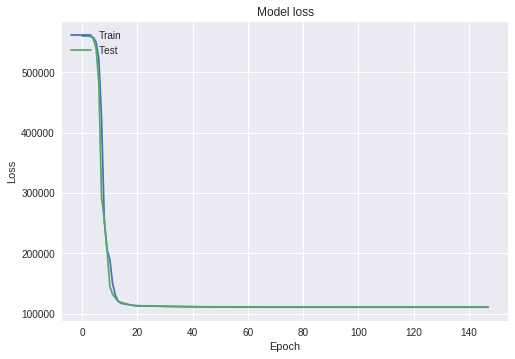

In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


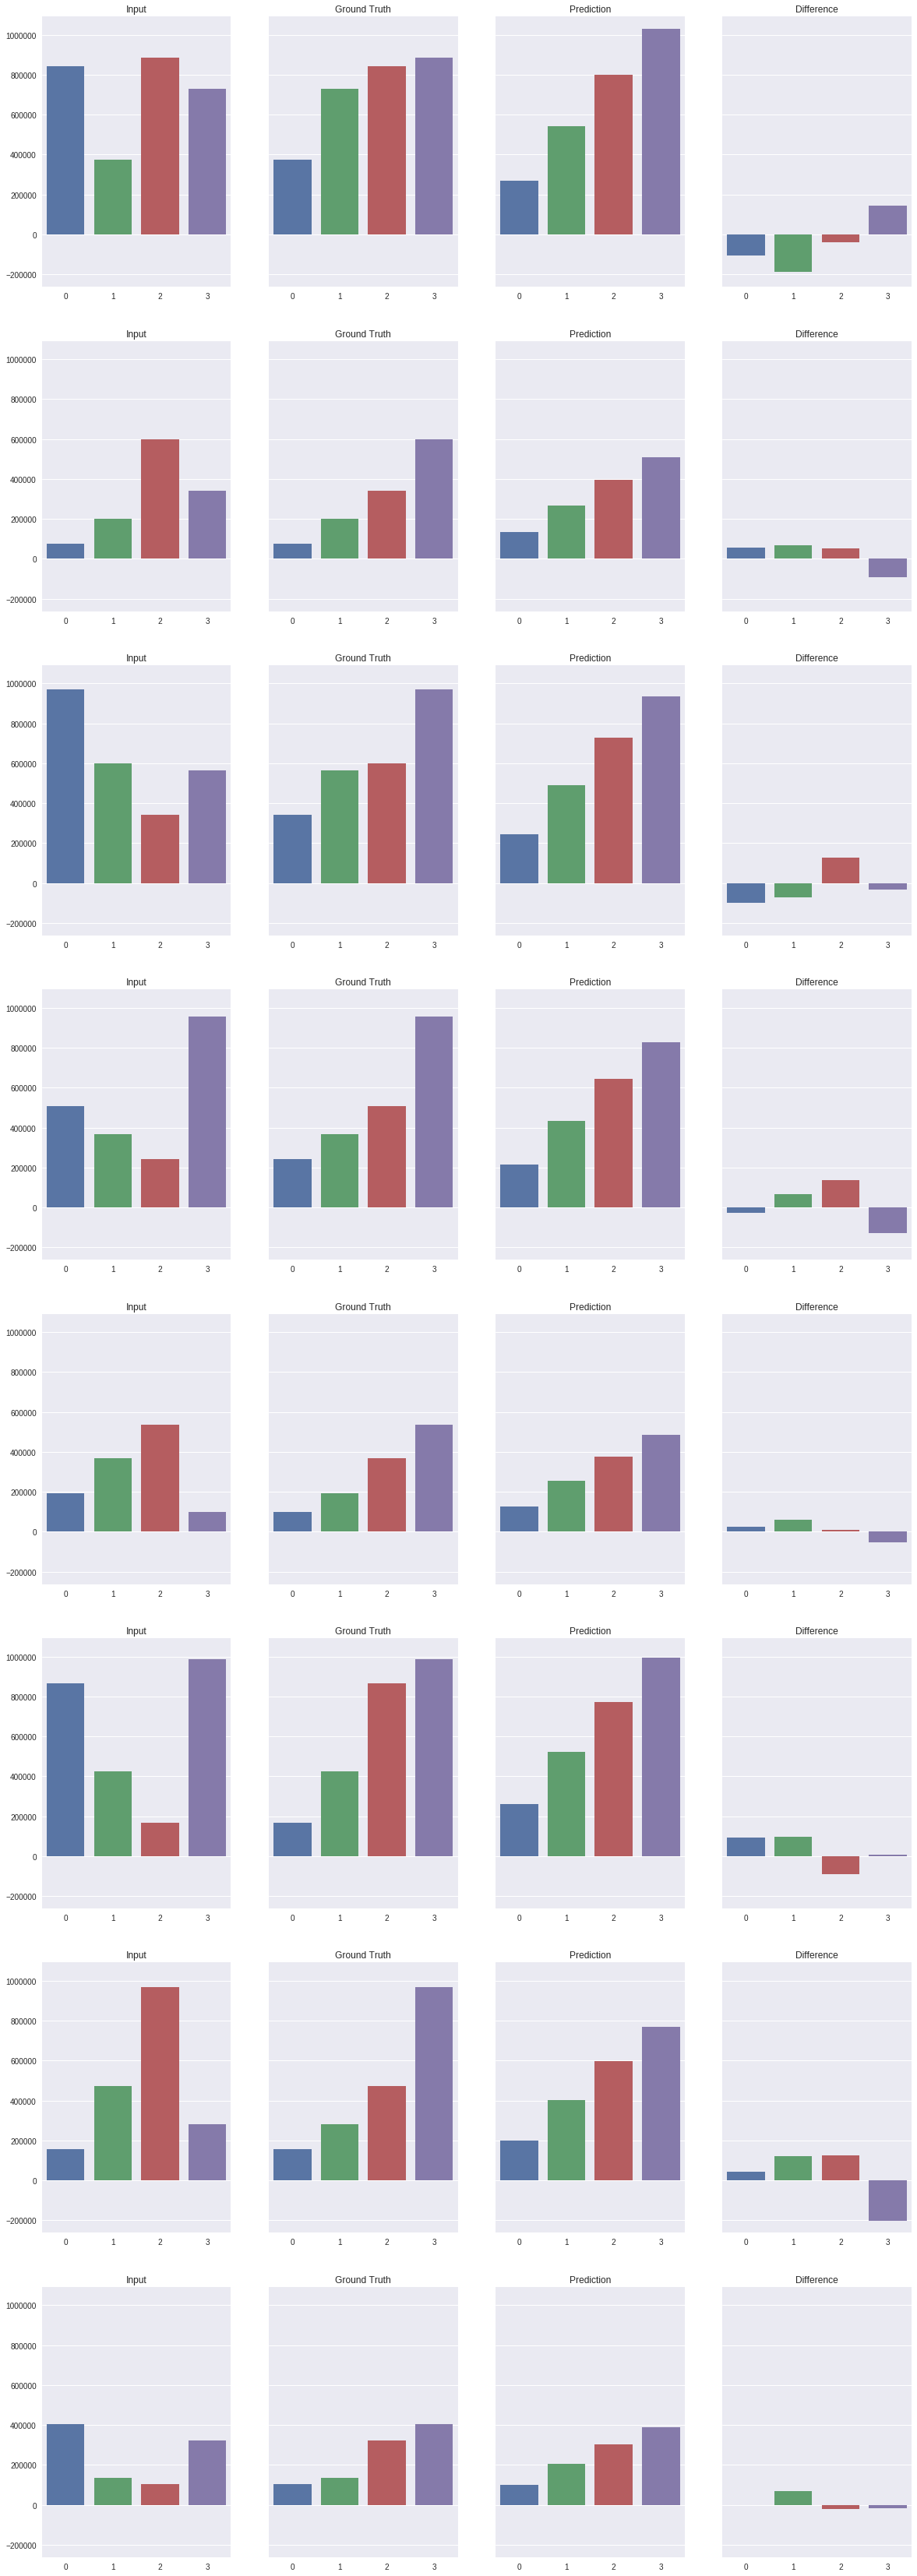

In [18]:
fig, axs = plt.subplots(test_samples, 4, sharey=True, figsize=(20, 60))
x = np.arange(size_to_sort)
for sample in range(test_samples):    
    _ = sns.barplot(x, X_test[sample], ax=axs[sample][0])
    _ = axs[sample][0].set_title("Input")

    _ = sns.barplot(x, y_test[sample], ax=axs[sample][1])
    _ = axs[sample][1].set_title("Ground Truth")

    _ = sns.barplot(x, prediction[sample], ax=axs[sample][2])
    _ = axs[sample][2].set_title("Prediction")

    _ = sns.barplot(x, prediction[sample] - y_test[sample], ax=axs[sample][3])
    _ = axs[sample][3].set_title("Difference")

plt.show()